# DOTA 2 Player Segmentation through Unsupervised Learning

Riley Stange<br>
Thinkful Data Science Capstone 3: Unsupervised Learning<br>
December 2019

The goal of this project is to take very detailed player gameplay statistics from Defense of The Ancients 2 (DOTA 2), and create clusters of player segmentations. DOTA 2 is a Multiplayer Online Battle Arena (MOBA) game, where two teams of 5 players have the goal of destroying the opposing team's "ancient," a stationary structure that is within each team's base, at opposite sides of the map. Each team has neverending waves of "minions," or computer controlled characters that continue to go down the three lanes, and, if the players were to not interfere, would end up in a deadlock at the center point of each lane. Players take turns at random choosing one character from an extensive roster of 119 (as of writing) characters, known as "heroes." When a player chooses a hero, no one else in the game can play as a copy of that character, as one could in some other similar games.

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings

sns.set_context("paper", font_scale=1.5)
warnings.filterwarnings("ignore")

# Data Exploration and Cleaning

The data was gathered from [OpenDota's second data dump](https://blog.opendota.com/2017/03/24/datadump2/), downloaded from their small subsample that they linked, which is originally comprised of a 4GB file, containing match information, and a 1GB file containing the skill rank of the matches, with the match id, so that it can be merged with the match data for further filtering.

This is how I loaded and filtered my data from a 4GB file that would've otherwise crashed my machine.
```
i = 1
for chunk in pd.read_csv("~\projects\Dota 2\player_matches_small.csv", chunksize=2500000, low_memory=False):
    chunk = chunk.loc[chunk['ability_uses'].notnull()].drop("account_id", 1)
    chunk.to_csv("~\projects\Dota 2\player_stats{}.csv".format(i), index=False)
    i += 1
```
I then appended these files into one dataframe
```
i = 16

player_stats = pd.DataFrame()

while i > 0:
    player_stats = player_stats.append(
        pd.read_csv(
            "~\projects\Dota 2\player_stats{}.csv".format(i)
        )
    )
    i -= 1
```
I then did the same for the file containing match_id and skill bracket, 2 being the highest, which is what I desire for my project.
```
i = 1
for chunk in pd.read_csv("~\projects\Dota 2\match_skill.csv", chunksize=2500000):
    chunk = chunk.loc[chunk['skill'] == 2]
    chunk.to_csv("~\projects\Dota 2\match_skill{}.csv".format(i), index=False)
    i += 1
```
Now with the data
```
i = 53

high_skill = pd.DataFrame()

while i > 0:
    high_skill = high_skill.append(
        pd.read_csv(
            "~\projects\Dota 2\match_skill{}.csv".format(i)
        )
    )
    i -= 1
```
I then performed an inner merge function to combine the two dataframes into one, using match_id as the key
```
skilled_player_matches = pd.merge(left=high_skill, right=player_stats, on="match_id")
```
And for later use, I wrote the result of the dataframe to a new CSV file, allowing me to dispose of all the small CSV files I generated earlier.
```
skilled_player_matches.to_csv("~\projects\Dota 2\skilled_player_matches.csv", index=False)
```

In [2]:
skilled_player_stats = pd.read_csv("~\projects\Dota 2\skilled_player_matches.csv")

In [3]:
skilled_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9289 entries, 0 to 9288
Data columns (total 56 columns):
match_id            9289 non-null int64
skill               9289 non-null int64
player_slot         9289 non-null int64
hero_id             9289 non-null int64
item_0              9289 non-null int64
item_1              9289 non-null int64
item_2              9289 non-null int64
item_3              9289 non-null int64
item_4              9289 non-null int64
item_5              9289 non-null int64
kills               9289 non-null int64
deaths              9289 non-null int64
assists             9289 non-null int64
leaver_status       9289 non-null float64
gold                9289 non-null float64
last_hits           9289 non-null int64
denies              9289 non-null int64
gold_per_min        9289 non-null int64
xp_per_min          9289 non-null int64
gold_spent          9289 non-null float64
hero_damage         9289 non-null float64
tower_damage        9289 non-null float64
her

The dataset is comprised of more than half seemingly non-numerical features. Lets look at the last 32 columns to see what they contain.

In [4]:
skilled_player_stats[skilled_player_stats.columns[24:40]]

,additional_units,stuns,max_hero_hit,times,gold_t,lh_t,xp_t,obs_log,sen_log,purchase_log,kills_log,buyback_log,lane_pos,obs,sen,actions
0,NaN,83.22880,"{""type"":""max_hero_hit"",""time"":1498,""max"":true,...","{0,60,120,180,240,300,360,420,480,540,600,660,...","{1,147,247,405,545,725,826,968,1300,1559,1872,...","{0,0,0,0,1,3,3,4,9,9,12,18,18,20,22,25,31,31,3...","{0,123,176,449,540,719,954,1149,1419,1532,1932...","{""{\""time\"":81,\""key\"":[172,106]}"",""{\""time\"":...","{""{\""time\"":2055,\""key\"":[132,104]}"",""{\""time\...","{""{\""time\"":-83,\""key\"":\""tango\""}"",""{\""time\""...","{""{\""time\"":1475,\""key\"":\""npc_dota_hero_huska...",{},"{""70"":{""76"":9},""72"":{""72"":10,""74"":5,""78"":2,""80...","{""108"":{""128"":1},""172"":{""106"":1}}","{""94"":{""96"":1},""132"":{""104"":1}}","{""1"":8243,""2"":256,""3"":41,""4"":464,""5"":86,""6"":10..."
1,NaN,14.45050,"{""type"":""max_hero_hit"",""time"":2657,""max"":true,...","{0,60,120,180,240,300,360,420,480,540,600,660,...","{1,277,543,888,1150,1417,1712,2087,2356,2784,3...","{0,3,7,9,13,17,20,23,27,31,36,36,37,40,41,45,5...","{0,123,331,604,942,1121,1413,2063,2605,2831,31...",{},{},"{""{\""time\"":-69,\""key\"":\""stout_shield\""}"",""{\...","{""{\""time\"":131,\""key\"":\""npc_dota_hero_arc_wa...",{},"{""72"":{""76"":3},""74"":{""76"":13},""76"":{""76"":24,""7...",{},{},"{""1"":5342,""2"":1,""3"":113,""4"":942,""5"":14,""6"":72,..."
2,NaN,126.21900,"{""type"":""max_hero_hit"",""time"":3011,""max"":true,...","{0,60,120,180,240,300,360,420,480,540,600,660,...","{1,101,287,430,530,671,1055,1203,1343,1649,179...","{0,0,2,3,3,4,7,8,9,14,15,18,18,23,25,27,29,31,...","{0,0,277,535,700,844,1386,1520,1706,2243,2325,...","{""{\""time\"":15,\""key\"":[156,96]}"",""{\""time\"":7...",{},"{""{\""time\"":-67,\""key\"":\""tango\""}"",""{\""time\""...","{""{\""time\"":660,\""key\"":\""npc_dota_hero_ancien...",{},"{""152"":{""130"":1},""154"":{""128"":1,""132"":1,""136"":...","{""118"":{""94"":1},""140"":{""90"":2},""146"":{""92"":1,""...",{},"{""1"":6144,""2"":108,""3"":105,""4"":231,""5"":106,""6"":..."
3,NaN,25.36180,"{""type"":""max_hero_hit"",""time"":2840,""max"":true,...","{0,60,120,180,240,300,360,420,480,540,600,660,...","{1,404,504,650,790,913,1110,1395,1856,2115,249...","{0,0,0,0,2,3,3,3,5,5,6,9,9,13,16,18,18,18,19,1...","{0,103,187,307,408,502,712,1073,1676,1862,2262...","{""{\""time\"":-29,\""key\"":[148,104]}"",""{\""time\""...",{},"{""{\""time\"":-87,\""key\"":\""courier\""}"",""{\""time...","{""{\""time\"":41,\""key\"":\""npc_dota_hero_arc_war...",{},"{""72"":{""76"":25},""74"":{""74"":1,""76"":11,""78"":1},""...","{""92"":{""122"":1,""124"":1},""116"":{""92"":2,""94"":1},...",{},"{""1"":4386,""2"":3,""4"":1165,""5"":156,""6"":64,""7"":4,..."
4,NaN,NaN,"{""type"":""max_hero_hit"",""time"":2638,""max"":true,...","{0,60,120,180,240,300,360,420,480,540,600,660,...","{1,201,378,646,787,924,1066,1251,1442,1819,208...","{0,0,2,6,7,8,9,11,13,16,20,24,28,32,35,35,37,3...","{0,255,668,1163,1225,1633,1973,2219,2489,2695,...",{},"{""{\""time\"":800,\""key\"":[140,90]}"",""{\""time\"":...","{""{\""time\"":-71,\""key\"":\""ward_sentry\""}"",""{\""...","{""{\""time\"":875,\""key\"":\""npc_dota_hero_huskar...","{""{\""time\"":2748}""}","{""70"":{""74"":39,""160"":6},""72"":{""76"":3,""160"":7,""...",{},"{""140"":{""90"":1},""178"":{""104"":1}}","{""1"":5422,""2"":241,""3"":1,""4"":1005,""5"":42,""6"":59..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284,NaN,8.69707,"{""type"":""max_hero_hit"",""time"":2559,""max"":true,...","{0,60,120,180,240,300,360,420,480,540,600,660,...","{0,237,423,646,946,1151,1251,1742,2340,2440,31...","{0,1,3,6,11,11,11,15,20,20,24,31,38,39,41,44,4...","{0,255,564,812,1493,2014,2127,2751,3279,3403,4...",{},{},"{""{\""time\"":-66,\""key\"":\""tango\""}"",""{\""time\""...","{""{\""time\"":404,\""key\"":\""npc_dota_hero_crysta...",{},"{""147"":{""118"":1,""119"":6},""148"":{""116"":1,""117"":...",{},{},NaN
9285,NaN,111.68000,"{

In [5]:
skilled_player_stats[skilled_player_stats.columns[-16:]]

,pings,purchase,gold_reasons,xp_reasons,killed,item_uses,ability_uses,hero_hits,damage,damage_taken,damage_inflictor,runes,killed_by,kill_streaks,multi_kills,life_state
0,"{""0"":29}","{""tango"":1,""flask"":1,""ward_observer"":2,""clarit...","{""0"":914,""1"":-3351,""6"":344,""11"":2418,""12"":7232...","{""0"":490,""1"":15563,""2"":13076}","{""npc_dota_creep_badguys_melee"":114,""npc_dota_...","{""tango"":4,""clarity"":1,""ward_observer"":2,""magi...","{""sandking_burrowstrike"":74,""sandking_sand_sto...","{""undefined"":62,""sandking_burrowstrike"":43,""an...","{""npc_dota_hero_nyx_assassin"":5891,""npc_dota_h...","{""npc_dota_hero_nyx_assassin"":3860,""npc_dota_c...","{""undefined"":4170,""sandking_burrowstrike"":8093...","{""5"":2}","{""npc_dota_hero_huskar"":1,""npc_dota_badguys_to...","{""3"":1}","{""2"":1,""3"":1}","{""0"":2769,""1"":16,""2"":447}"
1,"{""0"":52}","{""stout_shield"":1,""quelling_blade"":1,""tango"":1...","{""0"":712,""1"":-3143,""6"":1225,""11"":2478,""12"":703...","{""0"":158,""1"":19782,""2"":13381}","{""npc_dota_creep_badguys_melee"":121,""npc_dota_...","{""tango"":4,""branches"":1,""phase_boots"":119,""fla...","{""life_stealer_open_wounds"":26,""life_stealer_r...","{""ancient_apparition_chilling_touch"":16,""undef...","{""npc_dota_hero_arc_warden"":3993,""npc_dota_cre...","{""npc_dota_creep_badguys_ranged"":2143,""npc_dot...","{""ancient_apparition_chilling_touch"":767,""unde...","{""1"":1,""2"":1,""3"":1,""4"":1,""5"":1}","{""npc_dota_badguys_tower2_bot"":1,""npc_dota_cre...",{},"{""2"":1}","{""0"":2805,""1"":24,""2"":403}"
2,"{""0"":28}","{""tango"":1,""flask"":1,""clarity"":2,""boots"":1,""wa...","{""0"":955,""1"":-4790,""6"":25,""11"":1283,""12"":8944,...","{""0"":607,""1"":18052,""2"":9048}","{""npc_dota_creep_goodguys_melee"":51,""npc_dota_...","{""ward_observer"":6,""tango"":4,""flask"":1,""clarit...","{""nyx_assassin_spiked_carapace"":32,""nyx_assass...","{""undefined"":32,""nyx_assassin_spiked_carapace""...","{""npc_dota_hero_sand_king"":3860,""npc_dota_cree...","{""npc_dota_hero_sand_king"":5891,""npc_dota_hero...","{""undefined"":1618,""nyx_assassin_spiked_carapac...","{""3"":1,""5"":2}","{""npc_dota_hero_chaos_knight"":4,""npc_dota_hero...","{""3"":1}",{},"{""0"":2584,""1"":25,""2"":623}"
3,"{""0"":21}","{""courier"":1,""clarity"":1,""tango"":1,""ward_obser...","{""0"":625,""1"":-3410,""6"":1115,""11"":2419,""12"":721...","{""0"":47,""1"":14554,""2"":9068}","{""npc_dota_hero_arc_warden"":2,""npc_dota_creep_...","{""courier"":1,""ward_observer"":15,""tango"":4,""cla...","{""ancient_apparition_chilling_touch"":22,""ancie...","{""undefined"":56,""ancient_apparition_chilling_t...","{""npc_dota_hero_arc_warden"":3607,""npc_dota_cre...","{""npc_dota_creep_badguys_melee"":825,""npc_dota_...","{""undefined"":2674,""ancient_apparition_chilling...",{},"{""npc_dota_hero_huskar"":1,""npc_dota_hero_nyx_a...",{},{},"{""0"":2757,""1"":8,""2"":467}"
4,"{""0"":15}","{""ward_sentry"":1,""tango"":1,""stout_shield"":1,""s...","{""0"":882,""1"":-4161,""2"":-1651,""6"":492,""11"":2808...","{""0"":437,""1"":19292,""2"":13003}","{""npc_dota_creep_goodguys_melee"":2,""npc_dota_c...","{""tango"":4,""flask"":1,""ring_of_aquila"":6,""power...","{""riki_smoke_screen"":30,""riki_blink_strike"":42...","{""undefined"":144,""riki_blink_strike"":27,""ancie...","{""npc_dota_creep_badguys_melee"":42584,""npc_dot...","{""npc_dota_hero_dragon_knight"":4917,""npc_dota_...","{""undefined"":21586,""riki_blink_strike"":1474,""a...","{""2"":1,""5"":2}","{""npc_dota_hero_arc_warden"":1,""npc_dota_hero_l...","{""3"":2}","{""2"":1}","{""0"":2739,""1"":12,""2"":481}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284,"{""0"":4}","{""tango"":1,""stout_shield"":1,""ring_of_protectio...","{""0"":1431,""6"":750,""11"":4430,""12"":4149,""13"":564...","{""0"":1079,""1"":12797,""2"":13517,""3"":1847}","{""npc_dota_creep_badguys_melee"":3,""npc_dota_cr...","{""tango"":4,""clarity"":2,""ring_of_basilius"":1,""t...","{""ab

So, all 31 of these object columns contain dictionaries with various numerical values. It is unclear how deep some of these dictionaries go, so time to do some exploring to find out just how much dimensionality this dataset could potentially have! I can already see that the "times" and any column with the "_t" suffix is actually a list of numerical values, and would probably create far too much dimensionality.

## The Naive Approach

First, I will drop the "times" and columns columns ending with "_t", and all of the "_log" columns, as well as "actions", "additional_units" and "life_state," as I was having trouble normalizing them, and feel like I will have enough information to use without them.

In [6]:
skilled_player_stats_naive = skilled_player_stats.drop(
    columns=["actions", "additional_units", "times", 
             "gold_t", "lh_t", "xp_t", "max_hero_hit", 
             "obs_log", "sen_log", "purchase_log", 
             "kills_log", "buyback_log", "life_state"])

Now time to see what happens when we try to expand out the dictionaries keys into their own columns, with the values becoming the rows under those new columns.

In [7]:
skilled_player_stats_naive = pd.concat(
    [
        skilled_player_stats_naive,
        json_normalize(skilled_player_stats["lane_pos"].map(eval)).add_prefix(
            "lane_pos_"
        ),
        json_normalize(skilled_player_stats["obs"].map(eval)).add_prefix("obs_"),
        json_normalize(skilled_player_stats["killed"].map(eval)).add_prefix("killed_"),
        json_normalize(skilled_player_stats["item_uses"].map(eval)).add_prefix("used_"),
        json_normalize(skilled_player_stats["sen"].map(eval)).add_prefix("sen_"),
        json_normalize(skilled_player_stats["purchase"].map(eval)).add_prefix(
            "purchased_"
        ),
        json_normalize(skilled_player_stats["gold_reasons"].map(eval)).add_prefix(
            "gold_"
        ),
        json_normalize(skilled_player_stats["xp_reasons"].map(eval)).add_prefix("xp_"),
        json_normalize(skilled_player_stats["ability_uses"].map(eval)).add_prefix(
            "used_"
        ),
        json_normalize(skilled_player_stats["hero_hits"].map(eval)).add_prefix(
            "hero_hits_"
        ),
        json_normalize(skilled_player_stats["damage"].map(eval)).add_prefix("damage_"),
        json_normalize(skilled_player_stats["damage_taken"].map(eval)).add_prefix(
            "damaged_by_"
        ),
        json_normalize(skilled_player_stats["damage_inflictor"].map(eval)).add_prefix(
            "damaged_inflictor_"
        ),
        json_normalize(skilled_player_stats["runes"].map(eval)).add_prefix("runes_"),
        json_normalize(skilled_player_stats["killed_by"].map(eval)).add_prefix(
            "killed_by_"
        ),
        json_normalize(skilled_player_stats["kill_streaks"].map(eval)).add_prefix(
            "kill_streaks_"
        ),
        json_normalize(skilled_player_stats["multi_kills"].map(eval)).add_prefix(
            "multi_kills_"
        ),
        json_normalize(skilled_player_stats["pings"].map(eval)).add_prefix("pings"),
    ],
    axis=1,
)


Now to drop the columns that the new columns were derived from.

In [8]:
skilled_player_stats_naive = skilled_player_stats_naive.drop(
    columns=[
        "sen",
        "pings",
        "multi_kills",
        "kill_streaks",
        "killed_by",
        "runes",
        "damage_inflictor",
        "damage_taken",
        "damage",
        "hero_hits",
        "ability_uses",
        "xp_reasons",
        "gold_reasons",
        "purchase",
        "item_uses",
        "killed",
        "obs",
        "lane_pos",
    ]
)

And now to fill all the nulls with 0s.

In [9]:
skilled_player_stats_naive = skilled_player_stats_naive.fillna(0)

In [10]:
skilled_player_stats_naive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9289 entries, 0 to 9288
Columns: 11772 entries, match_id to pings0
dtypes: float64(11754), int64(18)
memory usage: 834.3 MB


That's a lot of dimensionality! Time to start scrunching it down with PCA.

In [11]:
X = skilled_player_stats_naive.drop(
    columns=["match_id", "hero_id", 
             "skill", "player_slot"]
)

First I will retain the first 21 columns and only perform PCA on the features that were derived from json_normalize, except for "pings", since it is a single column.

In [12]:
non_pca_cols = list(X[X.columns[:21]].columns)

In [13]:
non_pca_cols.append("pings0")

In [14]:
non_pca_cols

['item_0',
 'item_1',
 'item_2',
 'item_3',
 'item_4',
 'item_5',
 'kills',
 'deaths',
 'assists',
 'leaver_status',
 'gold',
 'last_hits',
 'denies',
 'gold_per_min',
 'xp_per_min',
 'gold_spent',
 'hero_damage',
 'tower_damage',
 'hero_healing',
 'level',
 'stuns',
 'pings0']

In [15]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X.drop(columns=non_pca_cols))

Using 34 components so I will have a total of 56 dimensions, just like I end up with in my "Informed Approach" that I will show later.

In [16]:
pca = PCA(n_components=34)
X_pca = pca.fit_transform(X_std)

In [17]:
pca.explained_variance_ratio_.sum()

0.2673026871243633

In [18]:
X_pca = pd.concat([X[non_pca_cols], pd.DataFrame(X_pca)], axis=1)

In [19]:
X_pca = scaler.fit_transform(X_pca)

### Clustering

#### K-Means

In [20]:
kmeans = KMeans(n_clusters=5)

In [21]:
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [22]:
y_pred = kmeans.predict(X_pca)

In [23]:
print(metrics.silhouette_score(X_pca, y_pred, metric='euclidean'))

0.08972787266227564


##### Visualization

##### PCA

In [24]:
pca = PCA(n_components=2)
pca_results = pd.DataFrame(pca.fit_transform(X_pca))

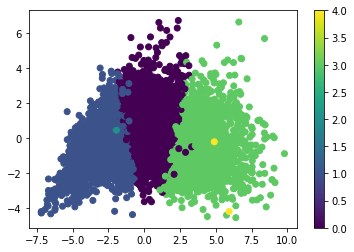

In [25]:
plt.scatter(x=pca_results[0], y=pca_results[1], c=y_pred)
plt.colorbar()
plt.show()

##### t-SNE

In [26]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, verbose=1)
%time tsne_results = pd.DataFrame(tsne.fit_transform(X_pca))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9289 samples in 0.033s...
[t-SNE] Computed neighbors for 9289 samples in 8.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9289
[t-SNE] Computed conditional probabilities for sample 2000 / 9289
[t-SNE] Computed conditional probabilities for sample 3000 / 9289
[t-SNE] Computed conditional probabilities for sample 4000 / 9289
[t-SNE] Computed conditional probabilities for sample 5000 / 9289
[t-SNE] Computed conditional probabilities for sample 6000 / 9289
[t-SNE] Computed conditional probabilities for sample 7000 / 9289
[t-SNE] Computed conditional probabilities for sample 8000 / 9289
[t-SNE] Computed conditional probabilities for sample 9000 / 9289
[t-SNE] Computed conditional probabilities for sample 9289 / 9289
[t-SNE] Mean sigma: 1.360308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.331055
[t-SNE] KL divergence after 300 iterations: 3.531728
Wall time: 40.7 s


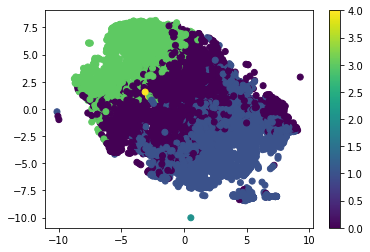

In [27]:
plt.scatter(x=tsne_results[0], y=tsne_results[1], c=y_pred)
plt.colorbar()
plt.show()

##### UMAP

In [28]:
umap = UMAP(n_neighbors=15, min_dist=0.6)
%time umap_results = pd.DataFrame(umap.fit_transform(X_pca))

Wall time: 19.5 s


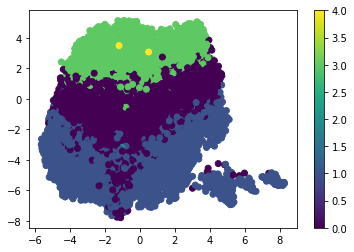

In [29]:
plt.scatter(x=umap_results[0], y=umap_results[1], c=y_pred)
plt.colorbar()
plt.show()

### Agglomerative

In [30]:
agg_cluster = AgglomerativeClustering(n_clusters=5)

y_pred = agg_cluster.fit_predict(X_pca)

In [31]:
print(metrics.silhouette_score(X_pca, y_pred, metric='euclidean'))

0.04640023836835955


#### Visualization

#### PCA

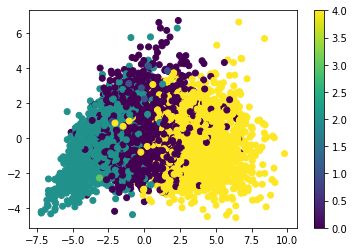

In [32]:
plt.scatter(x=pca_results[0], y=pca_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### t-SNE

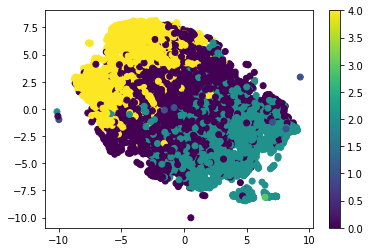

In [33]:
plt.scatter(x=tsne_results[0], y=tsne_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### UMAP

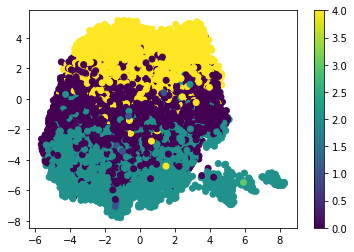

In [34]:
plt.scatter(x=umap_results[0], y=umap_results[1], c=y_pred)
plt.colorbar()
plt.show()

### HDBSCAN

In [35]:
hdbscan = HDBSCAN(min_cluster_size=5)

%time y_pred = hdbscan.fit_predict(X_pca)

Wall time: 5.31 s


In [36]:
print(metrics.silhouette_score(X_pca, y_pred, metric='euclidean'))

0.050170157495002456


#### Visualization

##### PCA

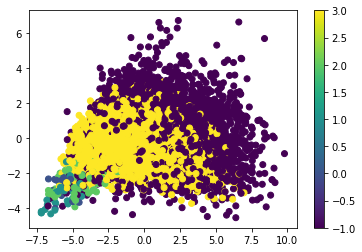

In [37]:
plt.scatter(x=pca_results[0], y=pca_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### t-SNE

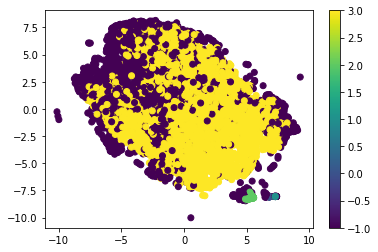

In [38]:
plt.scatter(x=tsne_results[0], y=tsne_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### UMAP

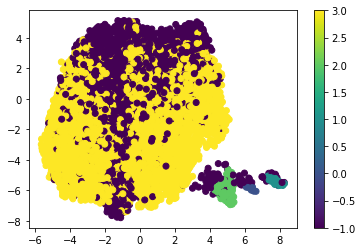

In [39]:
plt.scatter(x=umap_results[0], y=umap_results[1], c=y_pred)
plt.colorbar()
plt.show()

I felt it unnecessary to comment on any of these visualizations, as they all are fairly poor and noisy, with a lot of blending. This shows that the majority of the features in the dataset are confusing the models, and need to be dealt away with.

## The Informed Approach

There is a column called "leaver_status," a value greater than 0 indicates that the player left the game at a certain point. '

The different numbers indicate how the player left the game. 1 is where they disconnected, but reconnected within 5 minutes of disconnection, 2 is where they disconnected and didn't come back within 5 minutes of disconnecting, 3 is where they actually pressed the "Quit" button, and 4 is where they stayed connected to the game, but didn't actively participate. 

Since the game is team based, if a team is lacking one or more players, it will make that team perform worse, and the opposing team perform better, causing the data to not be an accurate representation of a player's usual behavior and performance.

In [40]:
skilled_player_stats['leaver_status'].value_counts()

0.0    9004
1.0     187
3.0      48
2.0      41
4.0       9
Name: leaver_status, dtype: int64

So I will filter out all players that were in a game where at least one player left(or was inactive) at any point in the game.

In [41]:
skilled_player_stats_informed = skilled_player_stats[
    ~skilled_player_stats["match_id"].isin( # No matches...
    skilled_player_stats[
        skilled_player_stats["leaver_status"] > 0]["match_id"])].reset_index(drop=True) # where a player left at any point

In [42]:
len(skilled_player_stats_informed)

7794

Filtered out over 1400 players, but still have a decent amount to work with.

Going to start with dropping the same columns that I dropped in the naive approach.

In [43]:
skilled_player_stats_informed = skilled_player_stats_informed.drop(
    columns=["leaver_status", "actions", "additional_units", "times", 
             "gold_t", "lh_t", "xp_t", "max_hero_hit", "obs_log", 
             "sen_log", "purchase_log", "kills_log", "buyback_log", 
             "life_state"])

In [44]:
skilled_player_stats_informed[skilled_player_stats_informed.columns[4:23]
                             ].head()

,item_0,item_1,item_2,item_3,item_4,item_5,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level
0,114,108,0,180,116,1,7,9,28,496.0,184,1,451,566,21625.0,15533.0,492.0,0.0,23
1,112,50,158,0,154,143,8,7,26,253.0,204,9,461,647,22675.0,13802.0,1871.0,2036.0,25
2,180,36,203,0,46,108,9,10,18,853.0,75,2,366,538,16430.0,12607.0,302.0,0.0,23
3,0,100,123,214,232,108,7,10,31,1006.0,77,7,388,459,19505.0,9431.0,448.0,0.0,21
4,196,63,71,139,154,30,11,9,20,2008.0,162,4,430,636,17620.0,15451.0,951.0,0.0,25


item_0-5 is useful as it tells what items each player had equipped at the end of their game, and the other columns so far seem to be useful and do not need to be dropped or engineered.

In [45]:
skilled_player_stats_informed[skilled_player_stats_informed.columns[23:43]
                             ].head()

,stuns,lane_pos,obs,sen,pings,purchase,gold_reasons,xp_reasons,killed,item_uses,ability_uses,hero_hits,damage,damage_taken,damage_inflictor,runes,killed_by,kill_streaks,multi_kills
0,83.2288,"{""70"":{""76"":9},""72"":{""72"":10,""74"":5,""78"":2,""80...","{""108"":{""128"":1},""172"":{""106"":1}}","{""94"":{""96"":1},""132"":{""104"":1}}","{""0"":29}","{""tango"":1,""flask"":1,""ward_observer"":2,""clarit...","{""0"":914,""1"":-3351,""6"":344,""11"":2418,""12"":7232...","{""0"":490,""1"":15563,""2"":13076}","{""npc_dota_creep_badguys_melee"":114,""npc_dota_...","{""tango"":4,""clarity"":1,""ward_observer"":2,""magi...","{""sandking_burrowstrike"":74,""sandking_sand_sto...","{""undefined"":62,""sandking_burrowstrike"":43,""an...","{""npc_dota_hero_nyx_assassin"":5891,""npc_dota_h...","{""npc_dota_hero_nyx_assassin"":3860,""npc_dota_c...","{""undefined"":4170,""sandking_burrowstrike"":8093...","{""5"":2}","{""npc_dota_hero_huskar"":1,""npc_dota_badguys_to...","{""3"":1}","{""2"":1,""3"":1}"
1,14.4505,"{""72"":{""76"":3},""74"":{""76"":13},""76"":{""76"":24,""7...",{},{},"{""0"":52}","{""stout_shield"":1,""quelling_blade"":1,""tango"":1...","{""0"":712,""1"":-3143,""6"":1225,""11"":2478,""12"":703...","{""0"":158,""1"":19782,""2"":13381}","{""npc_dota_creep_badguys_melee"":121,""npc_dota_...","{""tango"":4,""branches"":1,""phase_boots"":119,""fla...","{""life_stealer_open_wounds"":26,""life_stealer_r...","{""ancient_apparition_chilling_touch"":16,""undef...","{""npc_dota_hero_arc_warden"":3993,""npc_dota_cre...","{""npc_dota_creep_badguys_ranged"":2143,""npc_dot...","{""ancient_apparition_chilling_touch"":767,""unde...","{""1"":1,""2"":1,""3"":1,""4"":1,""5"":1}","{""npc_dota_badguys_tower2_bot"":1,""npc_dota_cre...",{},"{""2"":1}"
2,126.2190,"{""152"":{""130"":1},""154"":{""128"":1,""132"":1,""136"":...","{""118"":{""94"":1},""140"":{""90"":2},""146"":{""92"":1,""...",{},"{""0"":28}","{""tango"":1,""flask"":1,""clarity"":2,""boots"":1,""wa...","{""0"":955,""1"":-4790,""6"":25,""11"":1283,""12"":8944,...","{""0"":607,""1"":18052,""2"":9048}","{""npc_dota_creep_goodguys_melee"":51,""npc_dota_...","{""ward_observer"":6,""tango"":4,""flask"":1,""clarit...","{""nyx_assassin_spiked_carapace"":32,""nyx_assass...","{""undefined"":32,""nyx_assassin_spiked_carapace""...","{""npc_dota_hero_sand_king"":3860,""npc_dota_cree...","{""npc_dota_hero_sand_king"":5891,""npc_dota_hero...","{""undefined"":1618,""nyx_assassin_spiked_carapac...","{""3"":1,""5"":2}","{""npc_dota_hero_chaos_knight"":4,""npc_dota_hero...","{""3"":1}",{}
3,25.3618,"{""72"":{""76"":25},""74"":{""74"":1,""76"":11,""78"":1},""...","{""92"":{""122"":1,""124"":1},""116"":{""92"":2,""94"":1},...",{},"{""0"":21}","{""courier"":1,""clarity"":1,""tango"":1,""ward_obser...","{""0"":625,""1"":-3410,""6"":1115,""11"":2419,""12"":721...","{""0"":47,""1"":14554,""2"":9068}","{""npc_dota_hero_arc_warden"":2,""npc_dota_creep_...","{""courier"":1,""ward_observer"":15,""tango"":4,""cla...","{""ancient_apparition_chilling_touch"":22,""ancie...","{""undefined"":56,""ancient_apparition_chilling_t...","{""npc_dota_hero_arc_warden"":3607,""npc_dota_cre...","{""npc_dota_creep_badguys_melee"":825,""npc_dota_...","{""undefined"":2674,""ancient_apparition_chilling...",{},"{""npc_dota_hero_huskar"":1,""npc_dota_hero_nyx_a...",{},{}
4,NaN,"{""70"":{""74"":39,""160"":6},""72"":{""76"":3,""160"":7,""...",{},"{""140"":{""90"":1},""178"":{""104"":1}}","{""0"":15}","{""ward_sentry"":1,""tango"":1,""stout_shield"":1,""s...","{""0"":882,""1"":-4161,""2"":-1651,""6"":492,""11"":2808...","{""0"":437,""1"":19292,""2"":13003}","{""npc_dota_creep_goodguys_melee"":2,""npc_dota_c...","{""tango"":4,""flask"":1,""ring_of_aquila"":6,""power...","{""riki_smoke_screen"":30,""riki_blink_strike"":42...","{""undefined"":144,""riki_blink_strike"":27,""ancie...","{""npc_dota_creep_badguys_melee"":42584,""npc_dot...","{""npc_dota_hero_dragon_knight"":4917,""npc_dota_...","{""undefined"":21586,""riki_blink_strike"":1474,""a.

Time to check and see how complex some of these columns of dictionaries can get before evaluating their usefulness.

In [46]:
len(json_normalize(skilled_player_stats_informed["lane_pos"].map(eval)
                  ).columns)

5860

No, way too much dimensionality.

In [47]:
len(json_normalize(skilled_player_stats_informed["obs"].map(eval)
                  ).columns)

1169

Again, too much.

In [48]:
len(json_normalize(skilled_player_stats_informed["sen"].map(eval)
                  ).columns)

1739

Too much, yet again.

The "pings" column can easily be converted to just a single column of the amount of times a player marked a location of interest on the map, showing how active of a communicator they are.

In [49]:
skilled_player_stats_informed["pings"] = json_normalize(skilled_player_stats_informed["pings"].map(eval)
                                                       )

In [50]:
len(json_normalize(skilled_player_stats_informed["purchase"].map(eval)
                  ).columns)

196

This one isn't too bad, but still a bit much.

In [51]:
len(json_normalize(skilled_player_stats_informed["gold_reasons"].map(eval)
                  ).columns)

10

Okay, this one isn't too bad.

In [52]:
skilled_player_stats_informed = pd.concat([
    skilled_player_stats_informed,
    json_normalize(skilled_player_stats_informed["gold_reasons"].map(eval)).add_prefix("gold_reasons_")
    ], axis=1
)

In [53]:
len(json_normalize(skilled_player_stats_informed["xp_reasons"].map(eval)
                  ).columns)

4

Even better.

In [54]:
skilled_player_stats_informed = pd.concat([
    skilled_player_stats_informed,
    json_normalize(skilled_player_stats_informed["xp_reasons"].map(eval)).add_prefix("xp_reasons_")
    ], axis=1
)

In [55]:
len(json_normalize(skilled_player_stats_informed["killed"].map(eval)
                  ).columns)

285

Too much, and I think it is better to track what type of characters a player has killed by amount of damage dealt, as I will show later.

In [56]:
len(json_normalize(skilled_player_stats_informed["item_uses"].map(eval)
                  ).columns)

82

I'll try to scale and apply PCA to this set of features to see how much information it retains when reduced down to a reasonable amount of components.

In [57]:
scaler = StandardScaler()
item_uses_std = scaler.fit_transform(json_normalize(skilled_player_stats_informed["item_uses"].map(eval)
                                                   ).fillna(0)
                                    )
pca = PCA(n_components=10)

pca.fit_transform(item_uses_std)

pca.explained_variance_ratio_.sum()

0.2627235603009467

Since a lot of information is lost, and with how I don't see the amount of times a player uses a specific item to be all that useful to grouping players by their playstyle, I will not bother with this one.

As for "ability_uses" and "hero_hits" and "damage," it will probably be a similar situation, so I will also skip them due to time constraints.

"damage_taken" is interesting, where it seems like a lot of dimensionality, it can be filtered to only have columns containing neutral monsters, since there is a certain type of play style that will take a lot more damage from these neutral monsters than others, so I will sum up all the values from these columns containing the damage taken from neutral monsters, and make them into one single column, called "neutral_damage_taken."

In [58]:
neutral_cols = [col for col in json_normalize(skilled_player_stats_informed["damage_taken"].map(eval)
                                             ) if col.startswith('npc_dota_neutral')]

skilled_player_stats_informed["neutral_damage_taken"] = json_normalize(skilled_player_stats_informed["damage_taken"].map(eval)
                                                                      )[neutral_cols].sum(axis=1, skipna=True)
del neutral_cols

skilled_player_stats_informed["neutral_damage_taken"]

0         741.0
1        4084.0
2          90.0
3         885.0
4         152.0
         ...   
7789      547.0
7790       15.0
7791      200.0
7792    11114.0
7793       98.0
Name: neutral_damage_taken, Length: 7794, dtype: float64

I will create another feature in a similar way that I did with "neutral_damage_taken," except by how much damage a player does to enemy minions.

In [59]:
minion_cols = [col for col in json_normalize(skilled_player_stats_informed["damage"].map(eval)
                                            ) if col.startswith('npc_dota_creep')]

skilled_player_stats_informed['damage_to_minion'] = json_normalize(skilled_player_stats_informed["damage"].map(eval)
                                                                  )[minion_cols].sum(axis=1, skipna=True)
del minion_cols

skilled_player_stats_informed['damage_to_minion']

0       104883.0
1        74089.0
2        28502.0
3        29334.0
4        59530.0
          ...   
7789     51681.0
7790     63349.0
7791     18518.0
7792     65655.0
7793    132553.0
Name: damage_to_minion, Length: 7794, dtype: float64

"damage_inflictor" is a redundant feature, so I will drop that.

Now for "runes." Runes are power-up items that can be found on the map at certain locations.

In [60]:
len(json_normalize(skilled_player_stats_informed["runes"].map(eval)
                  ).columns)

7

Looks good

In [61]:
skilled_player_stats_informed = pd.concat([
    skilled_player_stats_informed,
    json_normalize(skilled_player_stats_informed["runes"].map(eval)).add_prefix("rune_")
], axis=1)

Now for "killed_by"

In [62]:
len(json_normalize(skilled_player_stats_informed["killed_by"].map(eval)
                  ).columns)

180

For that much dimensionality, I don't think this will be very helpful, just doesn't feel right.

Now for the final two columns that are kind of related: "kill_streaks" and "multi_kills"
A "kill_streak" is started when a player kills another player at least twice without dying.
A "multi_kill" is when a player kills more than one player in a short period of time.

In [63]:
len(json_normalize(skilled_player_stats_informed["kill_streaks"].map(eval)
                  ).columns)

8

In [64]:
len(json_normalize(skilled_player_stats_informed["multi_kills"].map(eval)
                  ).columns)

4

Nice, these both should add some value in differentiating very high performing offensive players without adding too much dimensionality.

In [65]:
skilled_player_stats_informed = pd.concat([
    skilled_player_stats_informed,
    json_normalize(skilled_player_stats_informed["kill_streaks"].map(eval)
                  ).add_prefix("kill_streak_"),
    json_normalize(skilled_player_stats_informed["multi_kills"].map(eval)
                  ).add_prefix("multi_kill_")
], axis=1)

Now to drop all the columns I won't need.

In [66]:
skilled_player_stats_informed = skilled_player_stats_informed.drop(
    columns=[
        "lane_pos", "obs", "sen", "purchase", "killed", "item_uses", 
        "ability_uses", "hero_hits", "damage", "damage_taken", 
        "damage_inflictor", "runes", "killed_by", "kill_streaks",
        "multi_kills", "gold_reasons", "xp_reasons", "skill"
    ]
).fillna(0)

In [67]:
skilled_player_stats_informed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7794 entries, 0 to 7793
Data columns (total 59 columns):
match_id                7794 non-null int64
player_slot             7794 non-null int64
hero_id                 7794 non-null int64
item_0                  7794 non-null int64
item_1                  7794 non-null int64
item_2                  7794 non-null int64
item_3                  7794 non-null int64
item_4                  7794 non-null int64
item_5                  7794 non-null int64
kills                   7794 non-null int64
deaths                  7794 non-null int64
assists                 7794 non-null int64
gold                    7794 non-null float64
last_hits               7794 non-null int64
denies                  7794 non-null int64
gold_per_min            7794 non-null int64
xp_per_min              7794 non-null int64
gold_spent              7794 non-null float64
hero_damage             7794 non-null float64
tower_damage            7794 non-null float64
hero_

### K-Means

Now, finally onto some clustering. First with K-means.

In [68]:
scaler = StandardScaler()
X_std = scaler.fit_transform(
    skilled_player_stats_informed.drop(
        columns=["match_id", "player_slot", "hero_id"]))

Since the dimensionality isn't that bad, I will skip straight to the clustering. I will do 5 clusters, since there are 5 defined roles in this type of game.

In [90]:
kmeans = KMeans(n_clusters=5, n_jobs=-1)

kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [91]:
y_pred = kmeans.predict(X_std)

In [93]:
print(metrics.silhouette_score(X_std, y_pred, metric='euclidean'))

0.06528273133809644


#### Visualization

##### PCA

In [71]:
pca = PCA(n_components=2)
%time pca_results = pd.DataFrame(pca.fit_transform(X_std))

Wall time: 18.9 ms


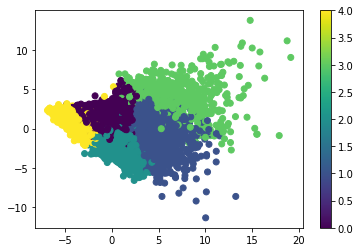

In [72]:
plt.scatter(x=pca_results[0], y=pca_results[1], c=y_pred)
plt.colorbar()
plt.show()

##### t-SNE

In [73]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, verbose=1)
%time tsne_results = pd.DataFrame(tsne.fit_transform(X_std))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7794 samples in 0.021s...
[t-SNE] Computed neighbors for 7794 samples in 5.631s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7794
[t-SNE] Computed conditional probabilities for sample 2000 / 7794
[t-SNE] Computed conditional probabilities for sample 3000 / 7794
[t-SNE] Computed conditional probabilities for sample 4000 / 7794
[t-SNE] Computed conditional probabilities for sample 5000 / 7794
[t-SNE] Computed conditional probabilities for sample 6000 / 7794
[t-SNE] Computed conditional probabilities for sample 7000 / 7794
[t-SNE] Computed conditional probabilities for sample 7794 / 7794
[t-SNE] Mean sigma: 1.709958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.543945
[t-SNE] KL divergence after 300 iterations: 3.471501
Wall time: 25.4 s


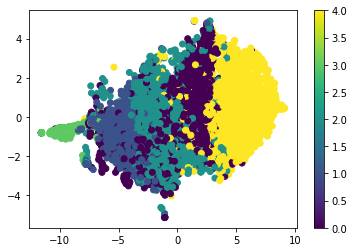

In [74]:
plt.scatter(x=tsne_results[0], y=tsne_results[1], c=y_pred)
plt.colorbar()
plt.show()

##### UMAP

In [75]:
umap = UMAP(n_neighbors=15, min_dist=0.6)
%time umap_results = pd.DataFrame(umap.fit_transform(X_std))

Wall time: 13.6 s


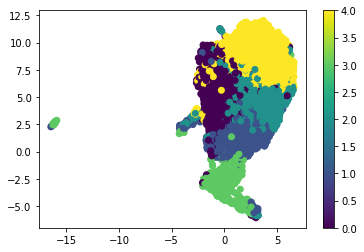

In [76]:
plt.scatter(x=umap_results[0], y=umap_results[1], c=y_pred)
plt.colorbar()
plt.show()

In terms of pure speed, K-Means wins, but I am not satisfied with the results. It mistook the far off outlier group discovered by UMAP to be a part of the closer lower part of the main cluster that is just starting to break away.

### Agglomerative

In [94]:
agg_cluster = AgglomerativeClustering(n_clusters=5)

y_pred = agg_cluster.fit_predict(X_std)

In [95]:
print(metrics.silhouette_score(X_std, y_pred, metric='euclidean'))

0.022524470671924212


#### Visualization

##### PCA

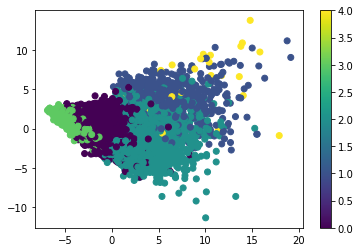

In [78]:
plt.scatter(x=pca_results[0], y=pca_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### t-SNE

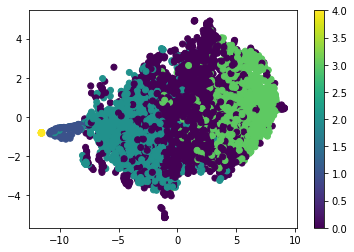

In [79]:
plt.scatter(x=tsne_results[0], y=tsne_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### UMAP

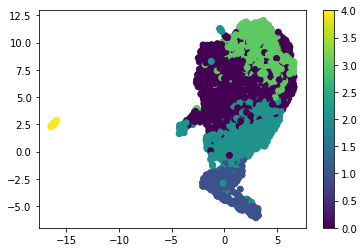

In [80]:
plt.scatter(x=umap_results[0], y=umap_results[1], c=y_pred)
plt.colorbar()
plt.show()

Oh, this looks promising. The UMAP and model agree that something is very odd about the cluster to the far left of the plot. Unless HDBSCAN does better, I think this will be my model of choice.

### HDBSCAN

In [169]:
hdbscan = HDBSCAN()

y_pred = hdbscan.fit_predict(X_std)

After seeing the visualizations for UMAP, I really liked HDBSCAN

#### Visualization

##### PCA

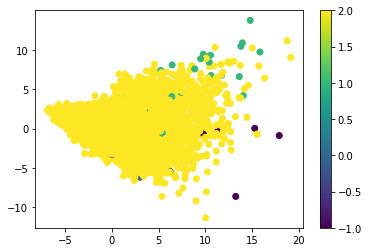

In [161]:
plt.scatter(x=pca_results[0], y=pca_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### t-SNE

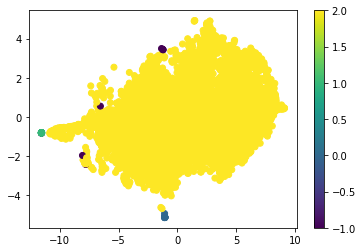

In [162]:
plt.scatter(x=tsne_results[0], y=tsne_results[1], c=y_pred)
plt.colorbar()
plt.show()

#### UMAP

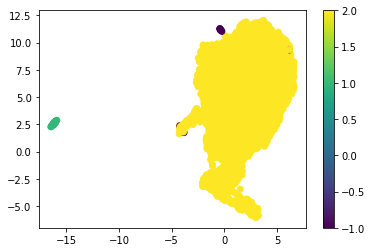

In [163]:
plt.scatter(x=umap_results[0], y=umap_results[1], c=y_pred)
plt.colorbar()
plt.show()

No matter how I tweak the min_cluster_size, HDBSCAN only seems able to differentiate the anomalies from the rest of the group, agreeing with the outlier groups that UMAP found. Tweaking it from 5 to 10 helped to display a second small cluster just starting to break off from the main cluster.

# Tuning My Best Model

I found that agglomerative with UMAP had a good result of detecting outliers, while still adding further divisions on the main visualized group. Something I want to try now is to feed the UMAP into the Agglomerative clustering model and see if I can get better definition on the large cluster, while still retaining accurate clustering of the small anomaly group.

## UMAP into Agglomerative

In [388]:
umap = UMAP(n_neighbors=20, min_dist=0.1)
%time umap_results = pd.DataFrame(umap.fit_transform(X_std))

Wall time: 15.4 s


In [398]:
agg_cluster = AgglomerativeClustering(n_clusters=5, linkage="ward")

y_pred = agg_cluster.fit_predict(umap_results)

In [396]:
# UMAP(n_neighbors=20, min_dist=0.1)
# AgglomerativeClustering(n_clusters=4, linkage="ward")
print(metrics.silhouette_score(umap_results, y_pred, metric='euclidean'))

0.39006191


In [393]:
# UMAP(n_neighbors=20, min_dist=0.1)
# AgglomerativeClustering(n_clusters=5, linkage="ward")
print(metrics.silhouette_score(umap_results, y_pred, metric='euclidean'))

0.39651504


In [391]:
# UMAP(n_neighbors=20, min_dist=0.1)
# AgglomerativeClustering(n_clusters=6, linkage="ward")
print(metrics.silhouette_score(umap_results, y_pred, metric='euclidean'))

0.38886502


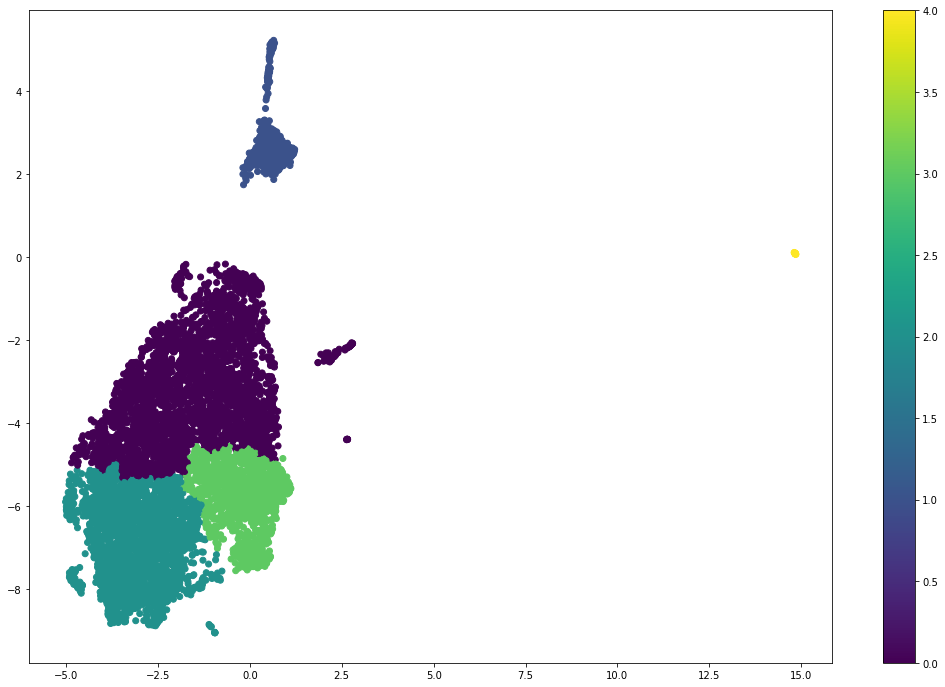

In [399]:
plt.figure(figsize=(18,12))
plt.scatter(x=umap_results[0], y=umap_results[1], c=y_pred)
plt.colorbar()
plt.show()

For tuning the model, I tried n_clusters and linkage settings, as well as a n_neighbors and min_dist in UMAP, and this was the best I could find. I feel satisfied with these results. I now have two clusters clearly divided from the rest of the larger main group, while the agglomerative clustering is still dividing the large group as well into three divisions, which would be helpful if I wanted to analyze those three player groups in more detail. However, I feel my time now is best spent on figuring out what makes the players in the two separated groups so different from the main cluster.

# Player Segmentation Analysis

In [400]:
skilled_player_stats_informed["cluster"] = y_pred

In [523]:
def melted_catplot(df, x_val, title):
    sns.catplot(
        data=df.melt(x_val, var_name="Legend", value_name="Count"),
        x=x_val,
        y="Count",
        hue="Legend",
        kind="bar",
        aspect=2.4,
    )
    plt.title(title)
    plt.show()

This function allows for me to do a bar plot with various columns and then group them by each player segment to easily visualize the differences between them based on different statistics.

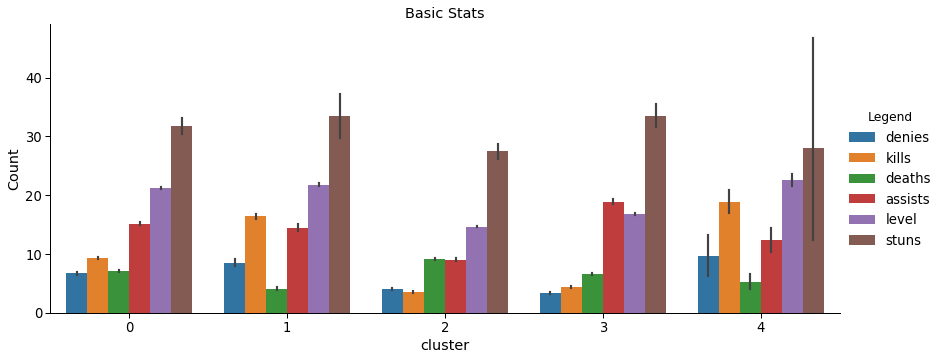

In [524]:
melted_catplot(
    skilled_player_stats_informed[
        ['denies', 'kills', 'deaths', 'assists',
         'level', 'stuns', 
         "cluster"]
    ],
    "cluster",
    "Basic Stats",
)

Before going into this first plot, a couple of stats need to be explained:

<br>**Denies**: When a player intentionally kills a friendly unit or teammate that is low on health in order to deny the opposing player from gaining gold, and reducing the experience gained from killing that unit.
<br>**Assists**: Granted if you deal damage to an enemy player, but don't get the killing blow.
<br>**Stuns**: Amount in total seconds (of stun) that the player inflicted at the end of the game.

Cluster 1 and 4 are pretty similar, except that Cluster 4 is a better version of 1, since 4 has less assists (meaning they got more killing blows). Interesting that cluster 3 has the most assists, perhaps a support player?

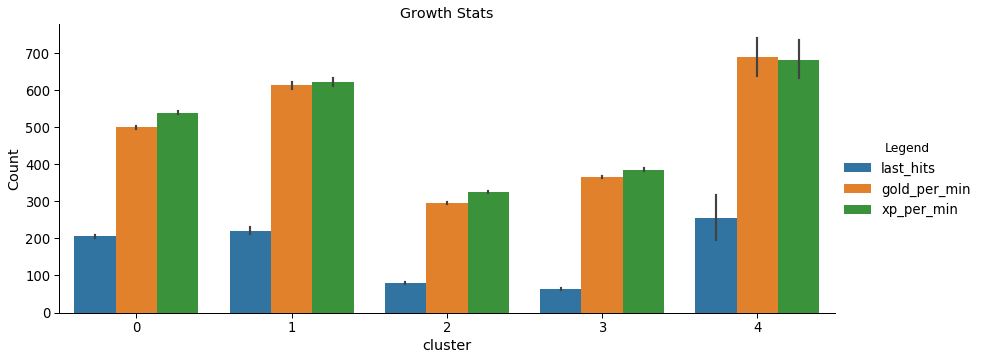

In [525]:
melted_catplot(
    skilled_player_stats_informed[
        ['last_hits', 'gold_per_min', 'xp_per_min',
         "cluster"]
    ],
    "cluster",
    "Growth Stats",
)

These stats are all connected with how fast a player is able to accumulate experience and gold, last hitting an enemy unit or player grants more experience and gold. The same differences are apparent as in the previous plot. It seems like 2 and 3 are support oriented, while 0 is more of a versatile player.

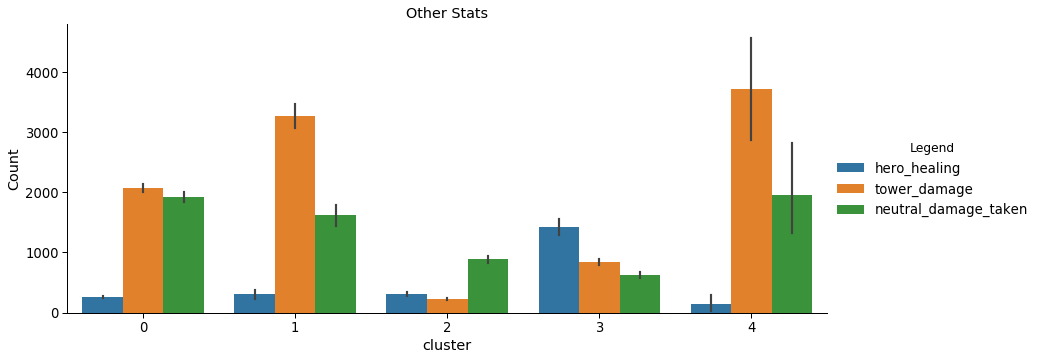

In [502]:
melted_catplot(
    skilled_player_stats_informed[
        ['hero_healing', 'tower_damage', 
         'neutral_damage_taken', 
         'cluster']
    ],
    "cluster",
    "Other Stats",
)


Here is where cluster 3 is very different fron the rest, with by far the most healing done. I would definitely call cluster 3 the "healer" player segment. 2 is fairly lackluster in these statistics, so players in this segment must contribute support in ways that do not show in the stats. I will refer to cluster 2 as "support".

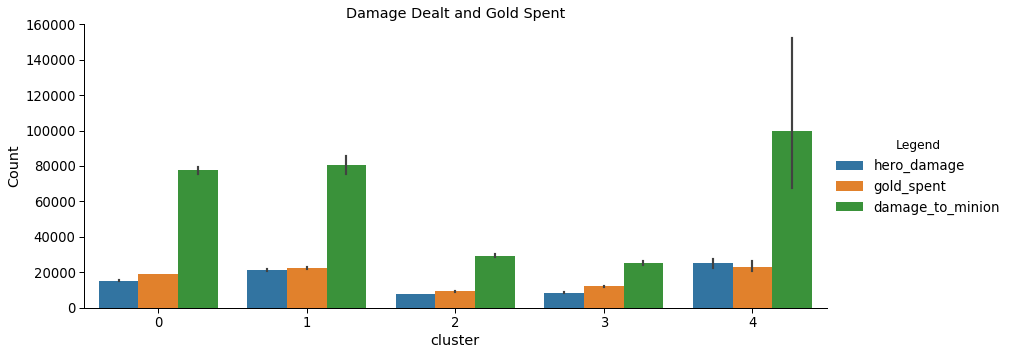

In [497]:
melted_catplot(
    skilled_player_stats_informed[
        ['hero_damage', 'gold_spent', 'damage_to_minion', 
         'cluster']
    ],
    "cluster",
    "Damage Dealt and Gold Spent",
)

Nothing really interesting about this chart.

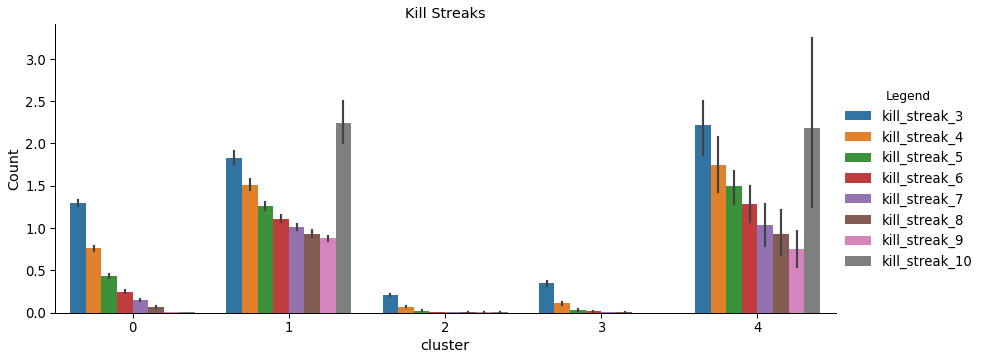

In [489]:
melted_catplot(
    skilled_player_stats_informed[
        ['kill_streak_3', 'kill_streak_4', 'kill_streak_5', 'kill_streak_6',
       'kill_streak_7', 'kill_streak_8', 'kill_streak_9', 'kill_streak_10', 'cluster']
    ],
    "cluster",
    "Kill Streaks",
)

**Kill Streak**: When a player kills another enemy player three times or more without dying. Once ten kill streak has been reached, they will continue to gain in this category, so it could also be seen as a 10+ kill streak.

This is definitely where cluster 1 and 4 really stand out. It's obvious cluster 4 is the "Hard-Carry", a player that starts out weak and vulnerable, but if they are able to stay alive long enough and gather gold and experience, they will be an unstoppable force that carries (thus the name) their team to victory. 1 would be what is called a Semi-Carry, where they are stronger more in the middle of the game, until they are then superceded in power by the Hard-Carry.

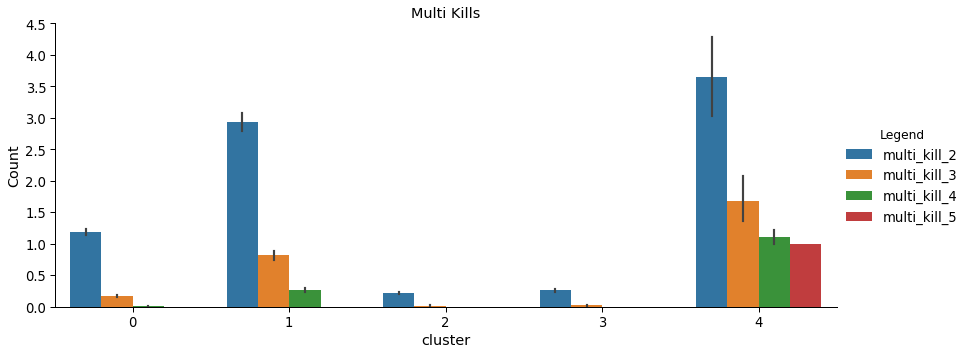

In [488]:
melted_catplot(
    skilled_player_stats_informed[
        ["multi_kill_2", "multi_kill_3", "multi_kill_4", "multi_kill_5", "cluster"]
    ],
    "cluster",
    "Multi Kills",
)

**Mult Kills**: This occurs when a player kills two or more players in a short window of time.

Here is where cluster 4: Hard-Carry really shines. The only one capable of wiping out the entire enemy team, and one of two capable of wiping out four at once, and the strongest at all other categories as well.

# Discussion

Before going into analysis, I did not expect anything more than being able to clearly detect more than two distinct playstyles, but now I have been able to use clustering and dimensionality reduction to group players into 5 distinct groups.

The findings from this research would be helpful firstly in helping video game developers to detect high performing players, and what character they were playing, as perhaps they may be playing a character that is overperforming, and need tweaking to bring a character into line with the rest of the lineup. Likewise, the same goes for underperforming characters that may need to be improved. Utilizing the UMAP, more unusual player behavior could be detected, where cheating may be involved, and then can be investigated more quickly when potentially detected.

The time saved from gaining better insights from gameplay data to develop and further balance an existing game is invaluable. Moreover, quickly being able to react to cheating and investigate suspicious behavior allows for the rest of a game's playerbase to have a better experience, preventing customer churn.

Also, this same approach can be applied to detecting fraudulent account transactions.